# TensorRT Example


## Prerequisites

This notebooks needs to be run in the `tempo-examples` conda environment defined below. Create from project root folder:

```bash
conda env create --name tempo-examples --file conda/tempo-examples.yaml
```

In [1]:
import os
from tempo.utils import logger
import logging
import numpy as np
from src.data import Cifar10

logger.setLevel(logging.ERROR)
logging.basicConfig(level=logging.ERROR)
ARTIFACTS_FOLDER = os.getcwd()+"/artifacts"
data = Cifar10()

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Create Tempo Artifacts

In [2]:
from tempo.serve.metadata import ModelFramework
from tempo.serve.model import Model

trt_model = Model(
    name="cifar10",
    platform=ModelFramework.TensorRT,
    local_folder=f"{ARTIFACTS_FOLDER}/tensorrt",
    uri="gs://seldon-models/triton/tf_cifar10",
    description="A TensorRT CIFAR10 Model",
    )

## Test Locally on Docker

In [3]:
from tempo.serve.loader import download
download(trt_model)

In [4]:
from tempo import deploy
remote_model = deploy(trt_model)

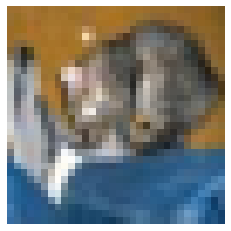

b'{"model_name":"cifar10","model_version":"1","outputs":[{"name":"fc10","datatype":"FP32","shape":[1,10],"data":[3.922544955514695e-9,1.2045545984273876e-11,2.660111908525664e-9,0.9999926090240479,2.5221330579583425e-10,5.408602419265662e-7,0.000006759544248780003,4.7511907602659775e-12,6.908747351985767e-9,1.0727558598377929e-11]}]}'


array([[3.9225450e-09, 1.2045546e-11, 2.6601119e-09, 9.9999261e-01,
        2.5221331e-10, 5.4086024e-07, 6.7595442e-06, 4.7511908e-12,
        6.9087474e-09, 1.0727559e-11]], dtype=float32)

In [5]:
from src.utils import show_image
show_image(data.X_test[0:1])
remote_model.predict(input_1=data.X_test[0:1])

In [6]:
remote_model.undeploy()

## Production Option 

### Prerequisites
 
Create a Kind Kubernetes cluster with Minio and Seldon Core installed using Ansible as described [here](https://tempo.readthedocs.io/en/latest/overview/quickstart.html#kubernetes-cluster-with-seldon-core).

In [7]:
!kubectl apply -f k8s/rbac -n production

secret/minio-secret configured
serviceaccount/tempo-pipeline unchanged
role.rbac.authorization.k8s.io/tempo-pipeline unchanged
rolebinding.rbac.authorization.k8s.io/tempo-pipeline-rolebinding unchanged


In [8]:
from tempo.examples.minio import create_minio_rclone
import os
create_minio_rclone(os.getcwd()+"/rclone.conf")

In [9]:
from tempo.serve.loader import upload
upload(trt_model)

In [10]:
from tempo.serve.metadata import KubernetesOptions
from tempo.seldon.k8s import SeldonCoreOptions
runtime_options = SeldonCoreOptions(
        k8s_options=KubernetesOptions(
            namespace="production",
            authSecretName="minio-secret"
        )
    )

In [11]:
from tempo import deploy
remote_model = deploy(trt_model, options=runtime_options)

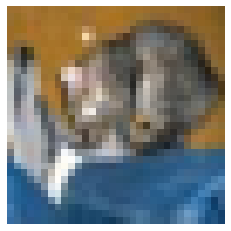

b'{"model_name":"cifar10","model_version":"1","outputs":[{"name":"fc10","datatype":"FP32","shape":[1,10],"data":[3.922544955514695e-9,1.2045545984273876e-11,2.660111908525664e-9,0.9999926090240479,2.5221330579583425e-10,5.408602419265662e-7,0.000006759544248780003,4.7511907602659775e-12,6.908747351985767e-9,1.0727558598377929e-11]}]}'


array([[3.9225450e-09, 1.2045546e-11, 2.6601119e-09, 9.9999261e-01,
        2.5221331e-10, 5.4086024e-07, 6.7595442e-06, 4.7511908e-12,
        6.9087474e-09, 1.0727559e-11]], dtype=float32)

In [12]:
from src.utils import show_image
show_image(data.X_test[0:1])
remote_model.predict(input_1=data.X_test[0:1])

### Illustrate use of Deployed Model by Remote Client

In [13]:
from tempo.seldon.k8s import SeldonKubernetesRuntime
k8s_runtime = SeldonKubernetesRuntime(runtime_options)
models = k8s_runtime.list_models(namespace="production")
print("Name\tDescription")
for model in models:
    details = model.get_tempo().model_spec.model_details
    print(f"{details.name}\t{details.description}")

Name	Description
cifar10	An TensorRT model


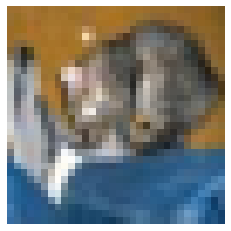

b'{"model_name":"cifar10","model_version":"1","outputs":[{"name":"fc10","datatype":"FP32","shape":[1,10],"data":[3.922544955514695e-9,1.2045545984273876e-11,2.660111908525664e-9,0.9999926090240479,2.5221330579583425e-10,5.408602419265662e-7,0.000006759544248780003,4.7511907602659775e-12,6.908747351985767e-9,1.0727558598377929e-11]}]}'


array([[3.9225450e-09, 1.2045546e-11, 2.6601119e-09, 9.9999261e-01,
        2.5221331e-10, 5.4086024e-07, 6.7595442e-06, 4.7511908e-12,
        6.9087474e-09, 1.0727559e-11]], dtype=float32)

In [14]:
from src.utils import show_image
show_image(data.X_test[0:1])
models[0].predict(input_1=data.X_test[0:1])

In [15]:
remote_model.undeploy()